# **Food Vision Model:  Food101**

We are making a model that predicting the images with the 101 classes.

For this Big and large model we need to GPU.

In [ ]:
!nvidia-smi

Fri Jul 28 20:04:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

## Use Tensorflow dataset to download dataset(TFDS)

In [ ]:
import tensorflow_datasets as tfds

dataset_list = tfds.list_builders()

print('food101'  in dataset_list )

True


### Load the dataset

In [ ]:
(train_data , test_data) , ds_info = tfds.load(name = 'food101',
                                               split = ['train' ,  'validation'],
                                               shuffle_files=True,
                                               as_supervised=True,
                                               with_info = True)


In [ ]:
 ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_name = ds_info.features['label'].names
class_name[:10]

In [ ]:
for image,label in  train_data.take(1):
    print(f"""
          image shape : {image.shape}
          image datatype: {image.dtype}
          traget class name : {label}
          class name str: {class_name[label.numpy()]}
          """)
    print(image)

(-0.5, 511.5, 511.5, -0.5)

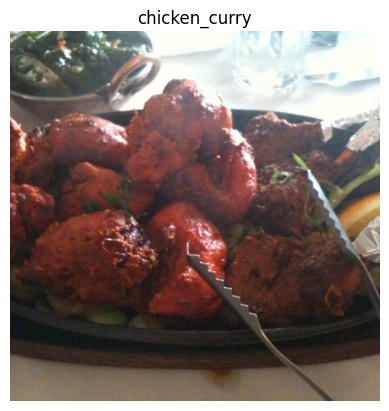

In [ ]:
plt.imshow(image)
plt.title(class_name[label.numpy()])
plt.axis(False)

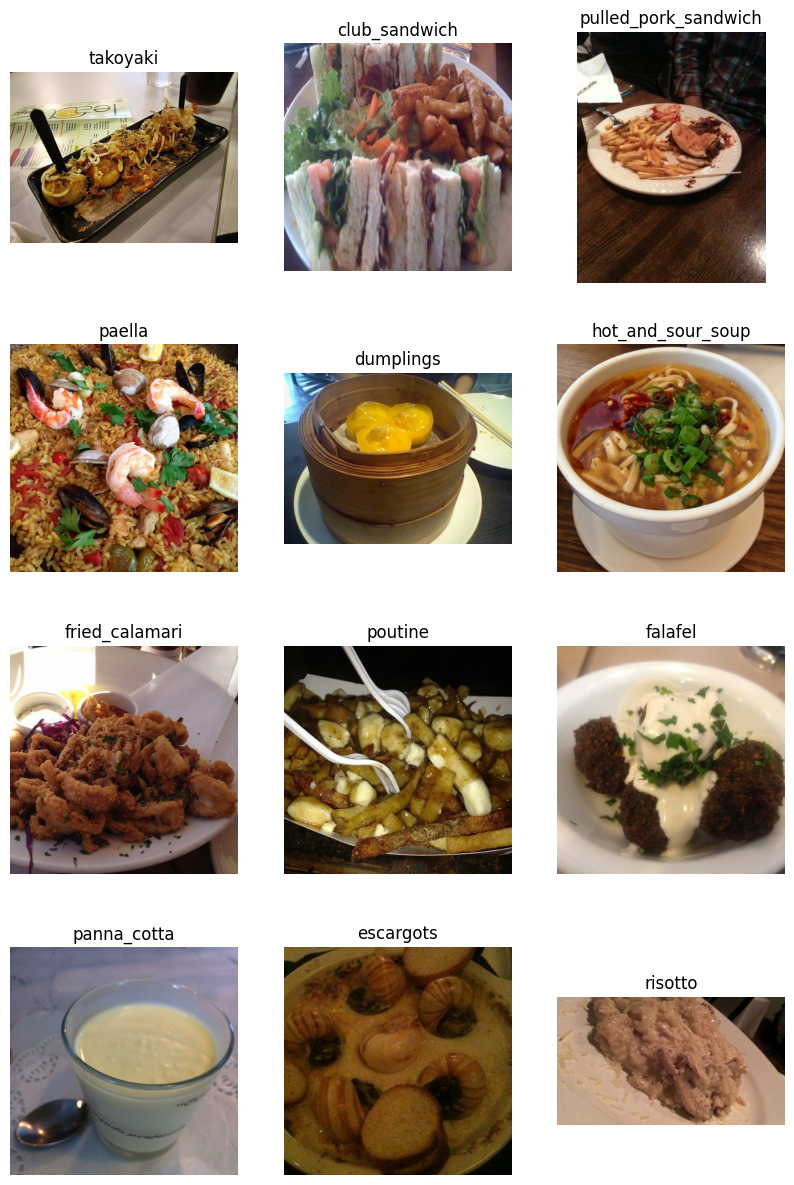

In [ ]:
i = 1
plt.figure(figsize = (10,15))
for image,label in train_data.take(12):
  plt.subplot(4,3,i)
  plt.imshow(image)
  plt.title(class_name[label.numpy()])
  plt.axis(False)
  i = i+1


## Creating Preprocessing Function for the data

As we can see that our data is different in size and scale

In [ ]:
def preprocessing_img(image , label , shape = 224):
  image = tf.image.resize(image , [shape , shape])
  image = image/255
  label = tf.one_hot(label , depth = 101)
  return tf.cast(image , dtype = 'float32'),label

## Batching & Preparing Data


Data input pipeline run faster in Map preprocessing function to training.

In [ ]:
train_data = train_data.map(map_func= preprocessing_img,
                            num_parallel_calls = tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)


test_data = test_data.map(map_func= preprocessing_img,
                          num_parallel_calls = tf.data.AUTOTUNE)\
                     .shuffle(buffer_size = 1000)\
                     .batch(batch_size = 32)\
                     .prefetch(buffer_size =tf.data.AUTOTUNE)



In [ ]:
train_data.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

## Plot loss curve helper function

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


# Truning Mixed precission training

> In mixed precission training the internal layer are train on the as we set and the external layers are store the values in the original form

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

## Building Feature extraction Model


### We are using three Net Architecture - *EfficientNetV2_B1, EfficientNet2S , ResNetV2_50*

In [ ]:
#effnet_b1 = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(include_top = False,
#                                                                  include_preprocessing=False)
effnet_2s =tf.keras.applications.efficientnet_v2.EfficientNetV2S(include_top = False,
                                                                   include_preprocessing=False)
#resnet50 = tf.keras.applications.resnet_v2.ResNet50V2(include_top = False)

#### Data Augumentation

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
data_augumentaion = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(.2),
    preprocessing.RandomHeight(.2),
    preprocessing.RandomWidth(.2),
    preprocessing.RandomZoom(.2),
] , name = 'Data_augumentaion')

In [ ]:
def create_model(base_model,input_shape = (224,224,3) , classes = 101):
  input = tf.keras.layers.Input(shape = input_shape , name = 'Input_layer')
  x = data_augumentaion(input)
  x = base_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D(name = "pooling_layer")(x)
  output = tf.keras.layers.Dense(classes , activation = 'softmax' , name ="Output_layer")(x)

  model = tf.keras.Model(input , output)

  return model

##### Model1

In [ ]:
effnet_b1.trainable = False
model = create_model(effnet_b1)
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = ["accuracy"])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_augumentaion (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b1 (Function  (None, None, None, 1280)  6931124  
 al)                                                             
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 Output_layer (Dense)        (None, 101)               129381    
                                                             

In [ ]:
model_history = model.fit(train_data ,
                          epochs = 5,
                          steps_per_epoch=int(.10* len(train_data)),
                          validation_data = test_data,
                          validation_steps = int(.1 * len(test_data)))

Epoch 1/5
236/236 [==============================] - ETA: 0s - loss: 3.9441 - accuracy: 0.1292

236/236 [==============================] - 151s 540ms/step - loss: 3.9441 - accuracy: 0.1292 - val_loss: 2.9753 - val_accuracy: 0.3315
Epoch 2/5
236/236 [==============================] - ETA: 0s - loss: 3.2252 - accuracy: 0.2646

236/236 [==============================] - 113s 479ms/step - loss: 3.2252 - accuracy: 0.2646 - val_loss: 2.4402 - val_accuracy: 0.4241
Epoch 3/5
236/236 [==============================] - ETA: 0s - loss: 2.9634 - accuracy: 0.3001

236/236 [==============================] - 94s 400ms/step - loss: 2.9634 - accuracy: 0.3001 - val_loss: 2.2351 - val_accuracy: 0.4569
Epoch 4/5
235/236 [============================>.] - ETA: 0s - loss: 2.8484 - accuracy: 0.3245

236/236 [==============================] - 84s 356ms/step - loss: 2.8467 - accuracy: 0.3244 - val_loss: 2.0980 - val_accuracy: 0.4723
Epoch 5/5
236/236 [==============================] - ETA: 0s - loss: 2.7295 - accuracy: 0.3481

236/236 [==============================] - 79s 336ms/step - loss: 2.7295 - accuracy: 0.3481 - val_loss: 1.9910 - val_accuracy: 0.4858


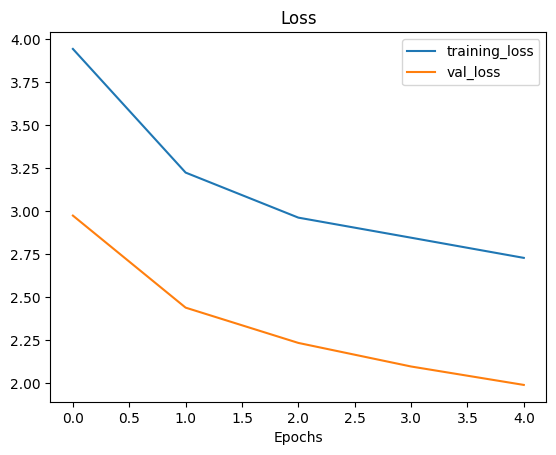

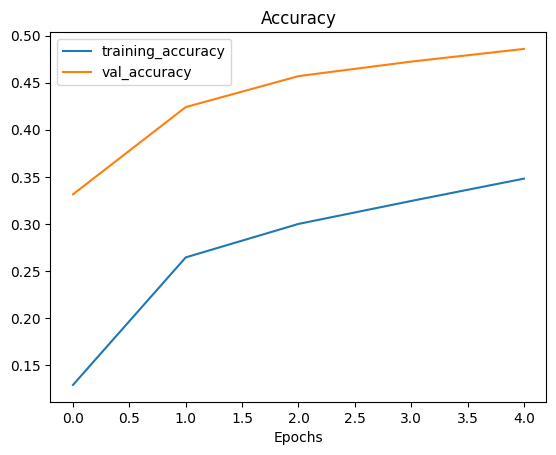

In [ ]:
plot_loss_curves(model_history)

##### Model2 efficientnet 2s

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: .07 - (epoch * .01))

In [ ]:
effnet_2s.trainable = False
model1 = create_model(effnet_2s)
model1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = ["accuracy"])


In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_augumentaion (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 Output_layer (Dense)        (None, 101)               129381    
                                                             

In [ ]:
model1_history = model1.fit(train_data ,
                          epochs = 3,
                          validation_data = test_data,
                          validation_steps = int(.15 * len(test_data)),
                          callbacks = [lr_scheduler])

Epoch 1/3
2368/2368 [==============================] - 733s 291ms/step - loss: 17.9518 - accuracy: 0.3205 - val_loss: 12.3924 - val_accuracy: 0.4976 - lr: 0.0700
Epoch 2/3
2368/2368 [==============================] - 410s 172ms/step - loss: 17.0697 - accuracy: 0.3872 - val_loss: 10.4690 - val_accuracy: 0.5437 - lr: 0.0600
Epoch 3/3
2368/2368 [==============================] - 330s 138ms/step - loss: 14.8342 - accuracy: 0.4141 - val_loss: 9.8675 - val_accuracy: 0.5373 - lr: 0.0500


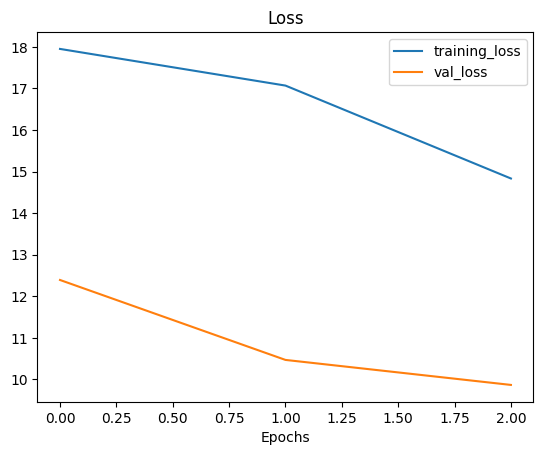

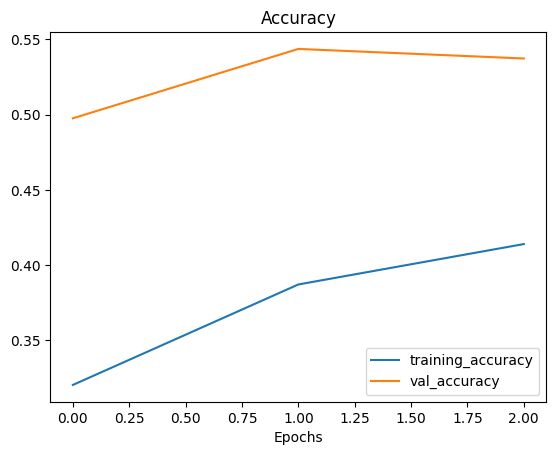

In [ ]:
plot_loss_curves(model1.history)

In [ ]:
model1.save_weights('/content/drive/MyDrive/Colab Notebooks/_eff/eff_2se5')

In [ ]:
model1.fit(train_data ,
                            initial_epoch = 3,
                          epochs = 5,
                          validation_data = test_data,
                          validation_steps = int(.15 * len(test_data)),
                          callbacks = [lr_scheduler])

Epoch 4/5
2368/2368 [==============================] - 299s 125ms/step - loss: 12.4997 - accuracy: 0.4351 - val_loss: 8.2295 - val_accuracy: 0.5736 - lr: 0.0400
Epoch 5/5
2368/2368 [==============================] - 284s 119ms/step - loss: 10.3028 - accuracy: 0.4554 - val_loss: 6.6419 - val_accuracy: 0.5882 - lr: 0.0300


In [ ]:
effnet_2s.trainable = True

for resnet_layer in effnet_2s.layers[:-18]:
  resnet_layer.trainable = False

for rl in effnet_2s.layers:
  print(rl.name , rl.trainable)


input_1 False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block1a_add False
block1b_project_conv False
block1b_project_bn False
block1b_project_activation False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_project_conv False
block2b_project_bn False
block2b_drop False
block2b_add False
block2c_expand_conv False
block2c_expand_bn False
block2c_expand_activation False
block2c_project_conv False
block2c_project_bn False
block2c_drop False
block2c_add False
block2d_expand_conv False
block2d_expand_bn False
block2d_expand_activation False
block2d_project_conv False
block2d_project_bn False
block2d_drop False
block2d_add False
block3a_expand_conv False
block3a_expand_bn False
block3a_expa

In [ ]:
model1_1 = create_model(effnet_2s)

In [ ]:
model1_1.compile(loss = 'categorical_crossentropy',
                 optimizer = 'Adam',
                 metrics = ['accuracy'])

In [ ]:
status = model1_1.load_weights('/content/drive/MyDrive/Colab Notebooks/_eff2s/eff_2se8')

In [ ]:
model1_1history = model1_1.fit(train_data , initial_epoch = 5,
                          epochs = 8,
                          validation_data = test_data,
                          validation_steps = int(.15 * len(test_data)),
                          callbacks = [lr_scheduler])

Epoch 6/8
2368/2368 [==============================] - 749s 299ms/step - loss: 5.9517 - accuracy: 0.3426 - val_loss: 1.7455 - val_accuracy: 0.6030 - lr: 0.0200
Epoch 7/8
2368/2368 [==============================] - 434s 182ms/step - loss: 2.2093 - accuracy: 0.4919 - val_loss: 1.4219 - val_accuracy: 0.6496 - lr: 0.0100
Epoch 8/8
2368/2368 [==============================] - 350s 147ms/step - loss: 2.0134 - accuracy: 0.5259 - val_loss: 1.4477 - val_accuracy: 0.6525 - lr: 0.0000e+00


In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: .01 - (epoch * .001))

In [ ]:
model1_1.save_weights('/content/drive/MyDrive/Colab Notebooks/_eff2s/eff_2se8')

In [ ]:
model1_1.fit(train_data , initial_epoch = 8,
                          epochs = 11,
                          validation_data = test_data,
                          validation_steps = int(.15 * len(test_data)),
                          callbacks = [lr_scheduler])

Epoch 9/11
2368/2368 [==============================] - 743s 299ms/step - loss: 1.6633 - accuracy: 0.5771 - val_loss: 1.0935 - val_accuracy: 0.6968 - lr: 0.0020
Epoch 10/11
2368/2368 [==============================] - 420s 176ms/step - loss: 1.5471 - accuracy: 0.6033 - val_loss: 1.0440 - val_accuracy: 0.7201 - lr: 0.0010
Epoch 11/11
2368/2368 [==============================] - 357s 149ms/step - loss: 1.5118 - accuracy: 0.6095 - val_loss: 1.0353 - val_accuracy: 0.7140 - lr: 0.0000e+00


In [ ]:
model1_1e5 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/eff_2se5')

In [ ]:
model1_1e5history = model1_1e5.fit(train_data , initial_epoch = 5,
                          epochs = 8,
                          validation_data = test_data,
                          validation_steps = int(.15 * len(test_data)),
                          callbacks = [lr_scheduler])

Epoch 6/8


In [ ]:
resnet50.trainable = False

model2 = create_model(resnet50)

model2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ['accuracy'])

In [ ]:
model2_history = model2.fit(train_data ,
                          epochs = 5,
                          steps_per_epoch=int(.1* len(train_data)),
                          validation_data = test_data,
                          validation_steps = int(.1 * len(test_data)))

Epoch 1/5
236/236 [==============================] - 110s 426ms/step - loss: 3.6333 - accuracy: 0.1900 - val_loss: 2.5687 - val_accuracy: 0.3576
Epoch 2/5
236/236 [==============================] - 78s 332ms/step - loss: 2.9037 - accuracy: 0.3183 - val_loss: 2.2833 - val_accuracy: 0.4276
Epoch 3/5
236/236 [==============================] - 72s 304ms/step - loss: 2.7362 - accuracy: 0.3460 - val_loss: 2.1948 - val_accuracy: 0.4521
Epoch 4/5
236/236 [==============================] - 62s 265ms/step - loss: 2.6698 - accuracy: 0.3751 - val_loss: 2.1084 - val_accuracy: 0.4747
Epoch 5/5
236/236 [==============================] - 192s 816ms/step - loss: 2.6405 - accuracy: 0.3694 - val_loss: 2.0214 - val_accuracy: 0.4933


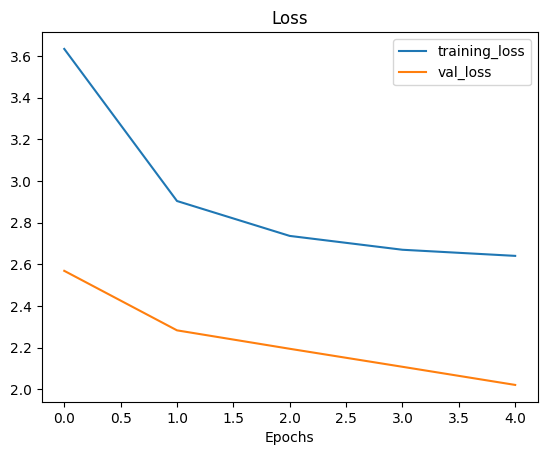

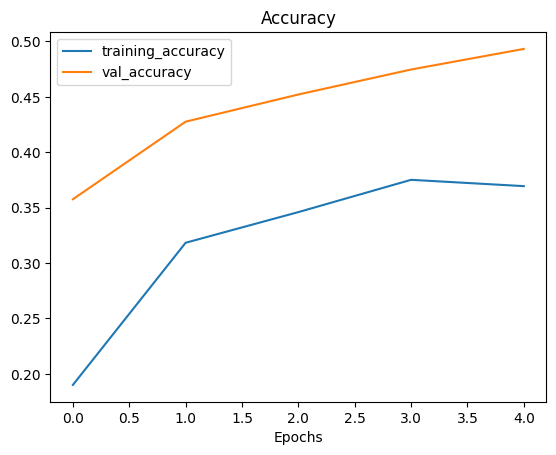

In [ ]:
plot_loss_curves(model2_history)

## Fine Tunnig the tree model

In [ ]:
resnet50.trainable = True

for resnet_layer in resnet50.layers[:-15]:
  resnet_layer.trainable = False

for rl in resnet50.layers:
  print(rl.name , rl.trainable)


In [ ]:
effnet_b1.trainable = True

for resnet_layer in effnet_b1.layers[:-18]:
  resnet_layer.trainable = False

for rl in effnet_b1.layers:
  print(rl.name , rl.trainable)


#### Model3

In [ ]:
model3 = create_model(effnet_b1)
model3.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                 optimizer = tf.keras.optimizers.Adam(learning_rate = .009),
                 metrics = ["accuracy"])


# Creating Model callBacks

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      verbose=0)

In [ ]:
model3_history = model3.fit(train_data ,
                          epochs = 3,
                          validation_data = test_data,
                          validation_steps = int(.25 * len(test_data)))

Epoch 1/3
2368/2368 [==============================] - 752s 305ms/step - loss: 2.5604 - accuracy: 0.3873 - val_loss: 1.6465 - val_accuracy: 0.5877
Epoch 2/3
2368/2368 [==============================] - 398s 167ms/step - loss: 2.1505 - accuracy: 0.4766 - val_loss: 1.4096 - val_accuracy: 0.6366
Epoch 3/3
2368/2368 [==============================] - 300s 126ms/step - loss: 1.9997 - accuracy: 0.5083 - val_loss: 1.3457 - val_accuracy: 0.6637


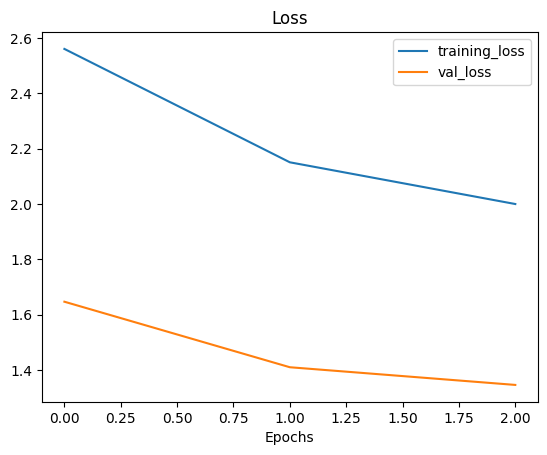

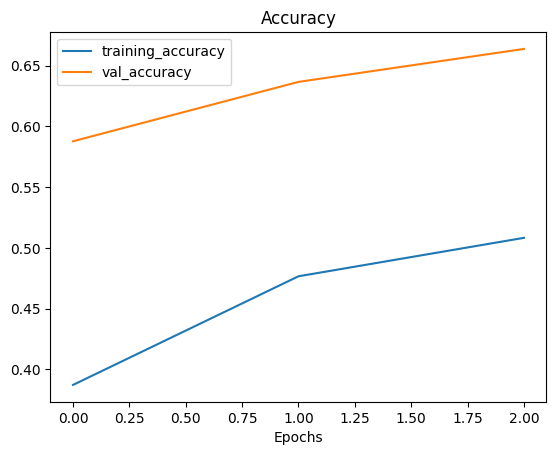

In [ ]:
plot_loss_curves(model3_history)

In [ ]:
model3.evaluate(test_data)

790/790 [==============================] - 90s 111ms/step - loss: 1.3376 - accuracy: 0.6608


[1.337601900100708, 0.6608316898345947]

## Ram is overflow so we are using saving, loading, training

In [ ]:
model3.save('/content/drive/MyDrive/Colab Notebooks/foodmodeleff_b1')

In [ ]:
model3_e3 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/foodmodeleff_b1')

In [ ]:
model3e3_history = model3_e3.fit(train_data ,
                      initial_epoch = 3,
                      epochs=4,
                      validation_data = test_data,
                      validation_steps = int(.15 * len(test_data)))

Epoch 4/4
2368/2368 [==============================] - 852s 351ms/step - loss: 1.9141 - accuracy: 0.5281 - val_loss: 1.2456 - val_accuracy: 0.6764


In [ ]:
model3_e3.save('/content/drive/MyDrive/Colab Notebooks/foodmodeleff_b1e4')

In [ ]:
model3_e4 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/foodmodeleff_b1e4')

In [ ]:
model3e4_history = model3_e4.fit(train_data ,
                      initial_epoch = 4,
                      epochs=6,
                      validation_data = test_data,
                      validation_steps = int(.15 * len(test_data)))

Epoch 5/6
2368/2368 [==============================] - 724s 297ms/step - loss: 1.8210 - accuracy: 0.5479 - val_loss: 1.3134 - val_accuracy: 0.6724
Epoch 6/6
2368/2368 [==============================] - 401s 168ms/step - loss: 1.7418 - accuracy: 0.5632 - val_loss: 1.2856 - val_accuracy: 0.6851


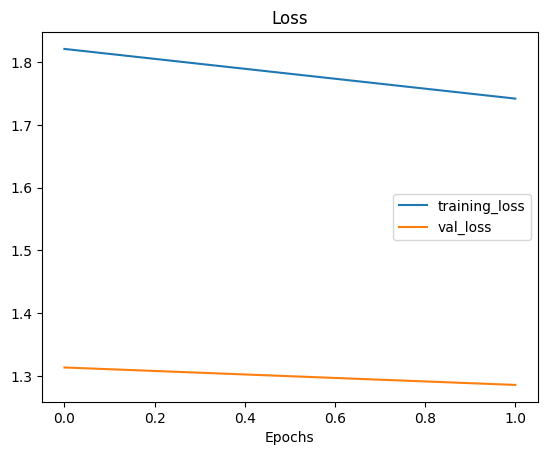

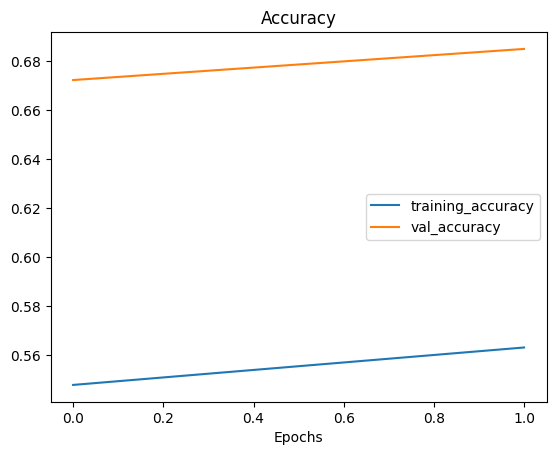

In [ ]:
plot_loss_curves(model3e4_history)

In [ ]:
model3_e4.evaluate(test_data)

790/790 [==============================] - 82s 98ms/step - loss: 1.2371 - accuracy: 0.6874


[1.2371090650558472, 0.6873663663864136]

In [ ]:
model3_e4.save('/content/drive/MyDrive/Colab Notebooks/foodmodeleff_b1e6')

##### Model 4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model4 = create_model(effnet_2s)
model4.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                 optimizer = tf.keras.optimizers.Adam(learning_rate = .01),
                 metrics = ["accuracy"])


In [ ]:
model4_history = model4.fit(train_data ,
                          epochs = 3,
                          validation_data = test_data,
                          validation_steps = int(.15 * len(test_data)))

Epoch 1/3
2368/2368 [==============================] - 762s 301ms/step - loss: 2.3246 - accuracy: 0.4414 - val_loss: 1.2891 - val_accuracy: 0.6555
Epoch 2/3
2368/2368 [==============================] - 427s 179ms/step - loss: 1.9158 - accuracy: 0.5323 - val_loss: 1.2302 - val_accuracy: 0.6774
Epoch 3/3
2368/2368 [==============================] - 355s 148ms/step - loss: 1.7441 - accuracy: 0.5703 - val_loss: 1.0621 - val_accuracy: 0.7158


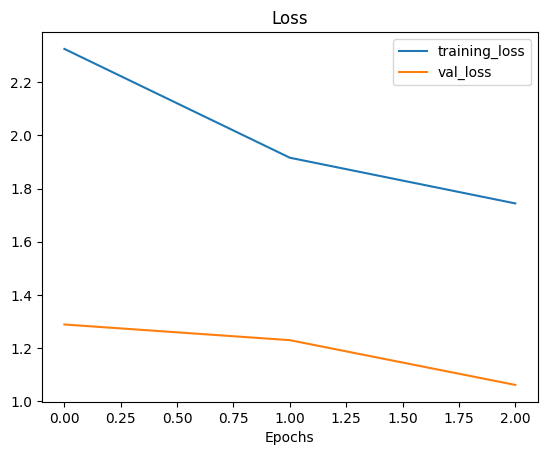

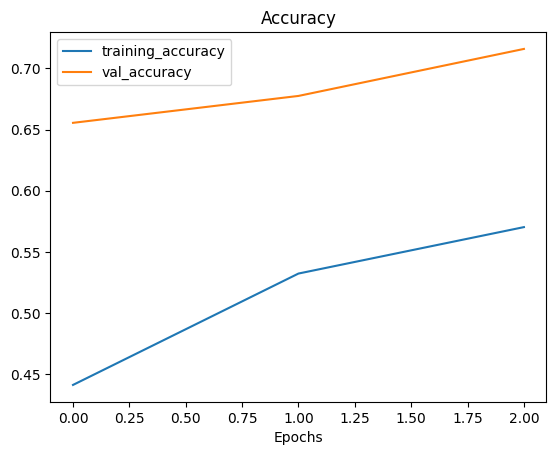

In [ ]:
plot_loss_curves(model4_history)

In [ ]:
model4.fit(train_data ,
           initial_epoch=3,
           epochs = 4,
           validation_data = test_data,
           validation_steps = int(.15 * len(test_data)))

Epoch 4/4
2368/2368 [==============================] - 326s 137ms/step - loss: 1.6491 - accuracy: 0.5909 - val_loss: 1.0049 - val_accuracy: 0.7352


In [ ]:
model4.save('/content/drive/MyDrive/Colab Notebooks/foodmodeleff_2se4')

In [ ]:
model4.evaluate(test_data)

In [ ]:
model4_e4 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/foodmodeleff_2se4')

In [ ]:
model4_e4history = model4_e4.fit(train_data ,
                      initial_epoch=4,
                      epochs = 8,
                      validation_data = test_data,
                      validation_steps = int(.15 * len(test_data)))

Epoch 5/8
2368/2368 [==============================] - 763s 306ms/step - loss: 1.5753 - accuracy: 0.6063 - val_loss: 1.0531 - val_accuracy: 0.7201
Epoch 6/8
2368/2368 [==============================] - 444s 186ms/step - loss: 1.4890 - accuracy: 0.6256 - val_loss: 1.0351 - val_accuracy: 0.7291
Epoch 7/8
2368/2368 [==============================] - ETA: 0s - loss: 1.4431 - accuracy: 0.6357

##### Model5

In [ ]:
effnet_2s.trainable = True

for resnet_layer in effnet_2s.layers[:-30]:
  resnet_layer.trainable = False

for rl in effnet_2s.layers:
  print(rl.name , rl.trainable)


In [ ]:
model5 = create_model(effnet_2s)
model5.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                 optimizer = tf.keras.optimizers.Adam(learning_rate = .02),
                 metrics = ["accuracy"])


In [ ]:
model5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_augumentaion (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 Output_layer (Dense)        (None, 101)               129381    
                                                             

In [ ]:
model5_history = model5.fit(train_data ,
                      initial_epoch=0,
                      epochs = 3,
                      validation_data = test_data,
                      validation_steps = int(.15 * len(test_data)))

Epoch 1/3
2368/2368 [==============================] - 756s 308ms/step - loss: 2.4381 - accuracy: 0.4310 - val_loss: 1.4385 - val_accuracy: 0.6234
Epoch 2/3
2368/2368 [==============================] - 446s 186ms/step - loss: 2.0068 - accuracy: 0.5206 - val_loss: 1.2906 - val_accuracy: 0.6727
Epoch 3/3
2368/2368 [==============================] - 367s 154ms/step - loss: 1.8682 - accuracy: 0.5525 - val_loss: 1.1158 - val_accuracy: 0.7084


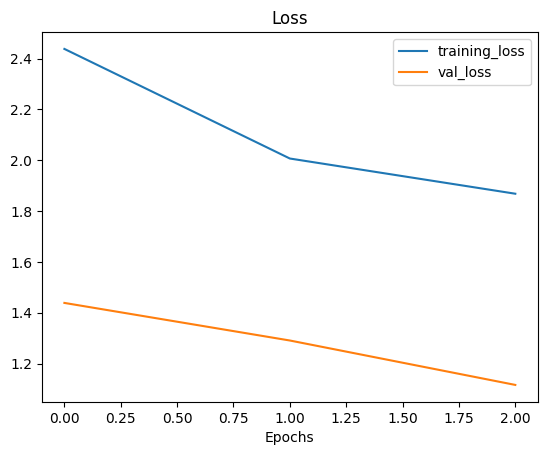

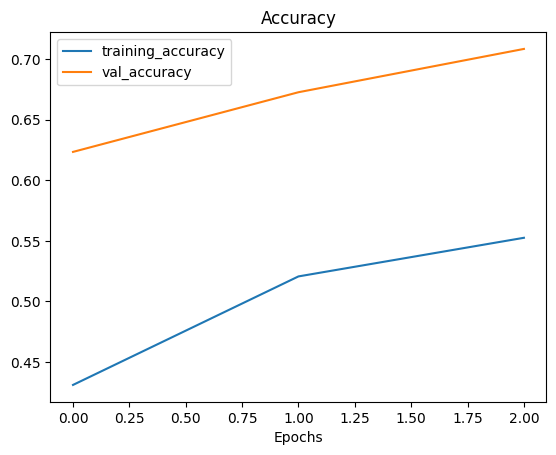

In [ ]:
plot_loss_curves(model5_history)

In [ ]:
model5_history = model5.fit(train_data ,
                      initial_epoch=22,
                      epochs = 25,
                      validation_data = test_data,
                      validation_steps = int(.15 * len(test_data)))



Epoch 23/25
2368/2368 [==============================] - 756s 308ms/step - loss: 0.9021 - accuracy: 0.7810 - val_loss: 0.9432 - val_accuracy: 0.78.06
Epoch 24/25
2368/2368 [==============================] - 446s 186ms/step - loss: 0.8068 - accuracy: 0.7906 - val_loss: 0.8706 - val_accuracy: 0.79.02
Epoch 25/25
2368/2368 [==============================] - 367s 154ms/step - loss: 0.7682 - accuracy: 0.8025 - val_loss: 0.7821 - val_accuracy: 0.8184
      
      


In [ ]:
def load_and_prep(filename , img_shape = 224):
  """
  Preprocessing the image file for the custom prediction

  Args : Filename (str) : give the name of the file in the format of the string

  Return : image shape of (244, 244, 3)
  """
  img = tf.io.read_file(filename)

  # trun into the numerical format

  img = tf.image.decode_image(img , channels = 3)

  img = tf.image.resize(img , size = (img_shape ,img_shape))

  return img/255.

#### Model 5
Predication



In [ ]:
def pred_plot(model,filename , class_name, img_shape = 224):
  """
   Args:
   model : A nueral network model that is used for the prediction
   filename ( str) : name of the file for the prediction
   class_name (var) : Classes arrary
  """
  img = load_and_prep(filename,  img_shape)

  pred = model.predict(tf.expand_dims(img,  axis=0))
  if len(pred[0]) > 1:
    index = tf.argmax(pred[0])
  else:
    index = int(tf.round(pred[0]))

  plt.imshow(img)
  plt.title(class_name[index])

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg


--2023-07-29 08:48:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.06s   

2023-07-29 08:48:10 (29.6 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



In [ ]:
pred = model5.predict(tf.expand_dims(load_and_prep('03-steak.jpeg') , axis = 0))

1/1 [==============================] - 5s 5s/step


In [ ]:
plt.imshow(img)
plt.title(classes[int(tf.round(pred)[0][0])])